In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import neattext.functions as nfx
import plotly.express as plx
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, GRU, GlobalMaxPooling1D,
    MultiHeadAttention, LayerNormalization, Dropout, Dense
)
from tensorflow.keras.models import Model

In [27]:
data=pd.read_csv('Suicide_Detection.csv', encoding='ISO-8859-1', low_memory=False)
print(data.head())

print(data['class'].value_counts())

print(data['class'].value_counts().index.values)

train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

print(train_data['class'].value_counts().index.values)

plx.bar(train_data,x=train_data['class'].value_counts().index.values,
        y=train_data['class'].value_counts(),color=['Suicide','Not Suicide'])


   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  Iâm so lostHello, my name is Adam (16) and I...      suicide
suicide        116037
non-suicide    116037
Name: class, dtype: int64
['suicide' 'non-suicide']
['suicide' 'non-suicide']


In [28]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

tmp_tokenizer = Tokenizer()
tmp_tokenizer.fit_on_texts(cleaned_train_text)

all_seqs = tmp_tokenizer.texts_to_sequences(cleaned_train_text)
lengths = [len(seq) for seq in all_seqs]
import numpy as np
for q in [50, 75, 80, 85, 90, 95, 99]:
    print(f'{q}th percentile: {np.percentile(lengths, q)}')


100%|█████████████████████████████████████████████████████████████████████████| 46415/46415 [00:01<00:00, 35435.68it/s]


50th percentile: 26.0
75th percentile: 64.0
80th percentile: 79.0
85th percentile: 99.0
90th percentile: 130.0
95th percentile: 191.0
99th percentile: 386.0


In [29]:
MAXLEN = 130

tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

print(cleaned_train_text)

train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=MAXLEN,padding='post',truncating='post')
test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=MAXLEN,padding='post',truncating='post')

print(train_text_pad)
print(train_text_pad.shape)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[[  436  3985  1618 ...     0     0     0]
 [ 1585 14877  1585 ...     0     0     0]
 [ 7413 59215   134 ...     0     0     0]
 ...
 [ 3095     2     5 ...     0     0     0]
 [    4   435     1 ...     0     0     0]
 [ 5133     2     5 ... 15975    46    52]]
(185659, 130)


In [30]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

import pickle
with open('glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [31]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

print(embedding_matrix)
print(embedding_matrix.shape)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.074482    0.58293003 -0.78233999 ... -0.24984001 -0.096953
   0.66692001]
 [-0.35394999  0.23051    -0.62689    ... -0.20720001  0.52003002
   0.51129001]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.29547    -0.21822999 -0.039817   ...  0.62642998  0.48798001
  -0.47554001]
 [ 0.75085002 -0.35099     0.37674999 ... -0.066863    0.79632998
  -0.05967   ]]
(271873, 300)


In [32]:

early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

inputs = Input(shape=(MAXLEN,), dtype='int32')
embedding_base = Embedding(
    input_dim=v+1,
    output_dim=300,
    weights=[embedding_matrix]
)
x = embedding_base(inputs)

x = GRU(64, return_sequences=True)(x)

attn = MultiHeadAttention(
    num_heads=4,
    key_dim=64,
    dropout=0.1
)(query=x, value=x, key=x)

x = LayerNormalization(epsilon=1e-6)(x + attn)
x = Dropout(0.1)(x)

x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)


In [33]:
embedding_base.trainable=False
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print(model.summary())
r1=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 130)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 130, 300)     81561900    ['input_5[0][0]']                
                                                                                                  
 gru_4 (GRU)                    (None, 130, 64)      70272       ['embedding_4[0][0]']            
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 130, 64)     66368       ['gru_4[0][0]',                  
 eadAttention)                                                    'gru_4[0][0]',            

In [34]:
embedding_base.trainable=True
model.compile(
    optimizer=tf.keras.optimizers.Nadam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print(model.summary())
r2=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=10,batch_size=256,callbacks=[early_stop,reducelr])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 130)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 130, 300)     81561900    ['input_5[0][0]']                
                                                                                                  
 gru_4 (GRU)                    (None, 130, 64)      70272       ['embedding_4[0][0]']            
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 130, 64)     66368       ['gru_4[0][0]',                  
 eadAttention)                                                    'gru_4[0][0]',            

In [35]:
probs = model.predict(test_text_pad)
preds = (probs > 0.5).astype(int).flatten()
print(classification_report(
    test_output,
    preds,
    target_names=lbl_target.inverse_transform([0, 1])
))

probs = model.predict(train_text_pad)
preds = (probs > 0.5).astype(int).flatten()
print(classification_report(
    train_output,
    preds,
    target_names=lbl_target.inverse_transform([0, 1])
))

1451/1451 [==============================] - 18s 12ms/step
              precision    recall  f1-score   support

 non-suicide       0.94      0.94      0.94     23209
     suicide       0.94      0.94      0.94     23206

    accuracy                           0.94     46415
   macro avg       0.94      0.94      0.94     46415
weighted avg       0.94      0.94      0.94     46415

5802/5802 [==============================] - 78s 13ms/step
              precision    recall  f1-score   support

 non-suicide       0.96      0.95      0.95     92828
     suicide       0.95      0.96      0.95     92831

    accuracy                           0.95    185659
   macro avg       0.95      0.95      0.95    185659
weighted avg       0.95      0.95      0.95    185659



In [60]:

import matplotlib.pyplot as plt
def plot_history(h, lab):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].plot(h.history['loss'], label='train')
    ax[0].plot(h.history['val_loss'], linestyle='--', label='val')
    ax[1].plot(h.history['accuracy'], label='train')
    ax[1].plot(h.history['val_accuracy'], linestyle='--', label='val')

    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()
    ax[0].grid(True)
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()

    plt.savefig(lab)
    plt.show()

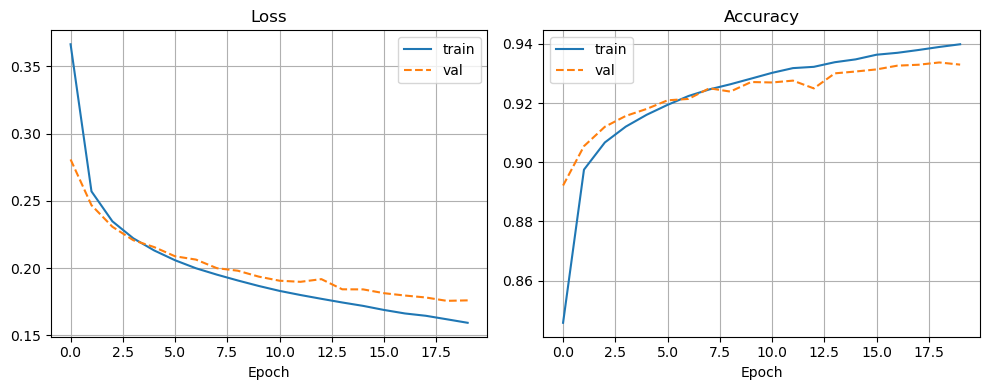

In [61]:
plot_history(r1, 'stage1.png')

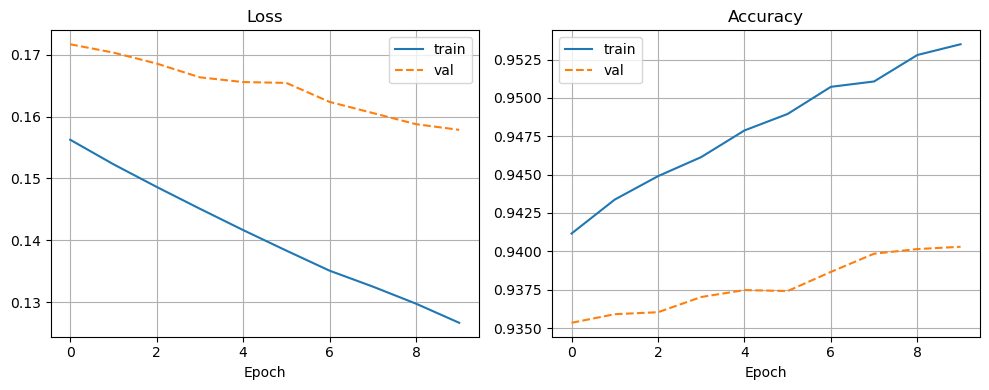

In [62]:
plot_history(r2, 'stage2.png')